In [223]:
import os
import cv2
import numpy as np
import math
import mediapipe as mp
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
import glob
import numpy as np
from tqdm.auto import tqdm
from loader.dataloader import SkeletonData


# I use self attention in this version

In [224]:
def find_adjacency_matrix():
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()
    adj = torch.zeros((21,21))
    for connection in mp_hands.HAND_CONNECTIONS:
        adj[connection[0],connection[1]] = 1
        adj[connection[1],connection[0]] = 1
    return adj 

In [225]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class GraphConvolution(nn.Module):
	def __init__(self, input_dim, output_dim, num_vetex, act=F.relu, dropout=0.0, bias=True):
		super(GraphConvolution, self).__init__()

		self.alpha = 1.

		self.act = act
		self.dropout = nn.Dropout(dropout)
		self.weight = nn.Parameter(torch.randn(input_dim, output_dim)).to(device)
		self.weight1 = nn.Parameter(torch.randn(input_dim, input_dim)).to(device)
		if bias:
			self.bias = nn.Parameter(torch.randn(output_dim)).to(device)
		else:
			self.bias = None

		for w in [self.weight]:
			nn.init.xavier_normal_(w)

	def normalize(self, m):
		rowsum = torch.sum(m, 0)
		r_inv = torch.pow(rowsum, -0.5)
		r_mat_inv = torch.diag(r_inv).float()

		m_norm = torch.mm(r_mat_inv, m)
		m_norm = torch.mm(m_norm, r_mat_inv)

		return m_norm

	def caculate_attention_matrix(self,x,adj):
		# score = torch.einsum("abd,dk->abk",x,self.weight1).to(device)
		# score = torch.einsum("abd,acd->abc",score,x).to(device)
		score = torch.einsum("abd,acd->abc",x,x).to(device)
		score = score*( (torch.ones(adj.shape) - adj).to(device) )
		return torch.softmax(score,dim=1).to(device) > 0.4
		

	def forward(self, adj, x):

		x = self.dropout(x)
		score = self.caculate_attention_matrix(x,adj)
		# K-ordered Chebyshev polynomial
		adj_norm = self.normalize(adj)
		sqr_norm = self.normalize(torch.mm(adj,adj))
		m_norm = (self.alpha*adj_norm + (1.-self.alpha)*sqr_norm).to(device)

		score = m_norm + score
		x_tmp = torch.einsum('abd,de->abe', x, self.weight)
		
		x_out = torch.einsum('aij,aid->ajd', score, x_tmp)
		if self.bias is not None:
			x_out += self.bias

		x_out = self.act(x_out)
		
		return x_out
		
		

class StandConvolution(nn.Module):
	def __init__(self, dims, num_classes, dropout = 0.0):
		super(StandConvolution, self).__init__()

		self.dropout = nn.Dropout(dropout)
		self.conv = nn.Sequential(
                        nn.Conv1d(dims[0], dims[1], kernel_size=3, stride=1,padding = 1),
                        nn.InstanceNorm1d(dims[1]),
                        nn.ReLU(inplace=True),
                        
                        #nn.AvgPool2d(3, stride=2),
                        nn.Conv1d(dims[1], dims[2], kernel_size=3, stride=1,padding = 1),
                        nn.Dropout(0.1),
                        nn.InstanceNorm1d(dims[2]),
                        nn.ReLU(inplace=True),
                        
                        #nn.AvgPool2d(3, stride=2),
                        nn.Conv1d(dims[2], dims[3], kernel_size=3, stride=1,padding = 1),
                        nn.Dropout(0.1),
                        nn.InstanceNorm1d(dims[3]),
                        nn.ReLU(inplace=True),
                        
                        #nn.AvgPool2d(3, stride=2)
                        ).to(device)
		self.fc = nn.Linear(64*21, num_classes).to(device)

	def forward(self, x):
		
		x = self.dropout(x.permute(0,2,1))
		x_tmp = self.conv(x)
		x_out = self.fc(x_tmp.view(x.size(0), -1))

		return x_out


In [226]:
class GGCN(nn.Module):
	def __init__(self, adj, num_classes, gc_dims, sc_dims, dropout=0.5):
		super(GGCN, self).__init__()

		terminal_cnt = 5
		actor_cnt = 1
		self.adj = adj + torch.eye(adj.size(0)).to(adj).detach()
		self.gcl = GraphConvolution(gc_dims[0], gc_dims[1], 21)
		self.conv= StandConvolution(sc_dims, num_classes)
  	
	def forward(self, x):
		
		multi_conv = self.gcl(self.adj, x) # 1,21,3
		logit = self.conv(multi_conv)
		return logit

In [227]:
def train(train_loader,model,criterion,optimizer,device):
    running_loss = 0
    model.train()
   
    for images,labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs,labels)
        running_loss += loss.item()
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    
    epoch_loss = running_loss / (len(train_loader))
    return model,epoch_loss,optimizer

def validate(valid_loader,model,criterion,device):
    model.eval()
    running_loss = 0
   
    
    for images,labels in tqdm(valid_loader):
       
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs,labels)
        running_loss += loss.item()

    epoch_loss = running_loss / (len(valid_loader))
    return model,epoch_loss

def get_accuracy(model,data_loader,device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = torch.argmax(outputs,1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
    return correct*100/total

def plot_losses(train_losses,valid_losses):
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_losses, color="blue", label="train_loss")
    ax1.plot(valid_losses, color="red", label="valid_loss")
    ax1.set(title="Loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax1.legend()
    
def plot_accuracy(train_acc,valid_acc):
    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_acc, color="blue", label="train_acc")
    ax1.plot(valid_acc, color="red", label="loss_acc")
    ax1.set(title="Accuracy over epochs",
            xlabel="Epoch",
            ylabel="Accuracy")
    ax1.legend()
    

In [228]:
train_set = SkeletonData("data/HaGRID/train.txt")
val_set = SkeletonData("data/HaGRID/val.txt")
test_set = SkeletonData("data/HaGRID/test.txt")

train_loader = DataLoader(train_set,batch_size = 128,drop_last = False)
valid_loader = DataLoader(val_set,batch_size = 512,drop_last = False)
test_loader = DataLoader(test_set,batch_size = 512,drop_last = False)

features =  947  class =  947
features =  313  class =  313
features =  324  class =  324


In [229]:
from util.evaluation import early_stopping

device = 'cuda:0'
model = GGCN(find_adjacency_matrix(),19,[3,9],[9, 16, 32, 64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 150
train_losses = []
valid_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(epochs):
    # training
    model,train_loss,optimizer = train(train_loader,model,criterion,optimizer,device)
    
    # validation
    with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, device)
    train_acc = get_accuracy(model,train_loader,device)
    val_acc = get_accuracy(model,valid_loader,device)
    print("Epoch {} --- Train loss = {} --- Valid loss = {} -- Train set accuracy = {} % Valid set Accuracy = {} %".format
          (epoch+1,train_loss,valid_loss,train_acc,val_acc))
    # save loss value
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    #save accuracy
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    
    best_val_accuracy,should_stop = early_stopping(val_accuracy,10)
    
    if should_stop:
        break
    
    if best_val_accuracy == val_accuracy[-1]:
        torch.save(model.state_dict(),"best_model.pth")
        print("Save best model ","Best_accuracy = ",get_accuracy(model,test_loader,device))
       

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 76.52it/s]


Epoch 1 --- Train loss = 4.0305721163749695 --- Valid loss = 3.0748794078826904 -- Train set accuracy = 10.559662090813093 % Valid set Accuracy = 8.945686900958467 %
Save best model  Best_accuracy =  11.728395061728396


100%|██████████| 1/1 [00:00<00:00, 72.32it/s]


Epoch 2 --- Train loss = 2.9129997193813324 --- Valid loss = 2.863656520843506 -- Train set accuracy = 15.311510031678987 % Valid set Accuracy = 13.099041533546325 %
Save best model  Best_accuracy =  14.506172839506172


100%|██████████| 1/1 [00:00<00:00, 94.74it/s]


Epoch 3 --- Train loss = 2.7776486575603485 --- Valid loss = 2.8729681968688965 -- Train set accuracy = 5.913410770855332 % Valid set Accuracy = 5.7507987220447285 %


100%|██████████| 1/1 [00:00<00:00, 82.65it/s]


Epoch 4 --- Train loss = 2.838043063879013 --- Valid loss = 2.801570177078247 -- Train set accuracy = 6.124604012671594 % Valid set Accuracy = 5.7507987220447285 %


100%|██████████| 1/1 [00:00<00:00, 82.23it/s]


Epoch 5 --- Train loss = 2.77273890376091 --- Valid loss = 2.6156818866729736 -- Train set accuracy = 13.305174234424499 % Valid set Accuracy = 13.099041533546325 %
Save best model  Best_accuracy =  14.814814814814815


100%|██████████| 1/1 [00:00<00:00, 107.61it/s]


Epoch 6 --- Train loss = 2.6289030760526657 --- Valid loss = 2.4092204570770264 -- Train set accuracy = 23.65364308342133 % Valid set Accuracy = 23.003194888178914 %
Save best model  Best_accuracy =  21.604938271604937


100%|██████████| 1/1 [00:00<00:00, 96.28it/s]


Epoch 7 --- Train loss = 2.4160631597042084 --- Valid loss = 2.209325075149536 -- Train set accuracy = 30.517423442449843 % Valid set Accuracy = 26.837060702875398 %
Save best model  Best_accuracy =  29.012345679012345


100%|██████████| 1/1 [00:00<00:00, 93.46it/s]


Epoch 8 --- Train loss = 2.2147152423858643 --- Valid loss = 2.0217087268829346 -- Train set accuracy = 36.95881731784583 % Valid set Accuracy = 33.22683706070288 %
Save best model  Best_accuracy =  36.41975308641975


100%|██████████| 1/1 [00:00<00:00, 86.96it/s]


Epoch 9 --- Train loss = 2.040686786174774 --- Valid loss = 1.8423793315887451 -- Train set accuracy = 44.56177402323126 % Valid set Accuracy = 40.2555910543131 %
Save best model  Best_accuracy =  41.97530864197531


100%|██████████| 1/1 [00:00<00:00, 101.33it/s]


Epoch 10 --- Train loss = 1.8822213560342789 --- Valid loss = 1.683575987815857 -- Train set accuracy = 52.37592397043294 % Valid set Accuracy = 46.325878594249204 %
Save best model  Best_accuracy =  52.77777777777778


100%|██████████| 1/1 [00:00<00:00, 90.42it/s]


Epoch 11 --- Train loss = 1.7218260765075684 --- Valid loss = 1.5567694902420044 -- Train set accuracy = 56.599788806758184 % Valid set Accuracy = 52.3961661341853 %
Save best model  Best_accuracy =  55.55555555555556


100%|██████████| 1/1 [00:00<00:00, 68.34it/s]


Epoch 12 --- Train loss = 1.6008207648992538 --- Valid loss = 1.4614191055297852 -- Train set accuracy = 58.60612460401267 % Valid set Accuracy = 53.674121405750796 %
Save best model  Best_accuracy =  58.333333333333336


100%|██████████| 1/1 [00:00<00:00, 101.41it/s]


Epoch 13 --- Train loss = 1.486087828874588 --- Valid loss = 1.3849265575408936 -- Train set accuracy = 60.82365364308342 % Valid set Accuracy = 55.91054313099041 %
Save best model  Best_accuracy =  60.18518518518518


100%|██████████| 1/1 [00:00<00:00, 80.15it/s]


Epoch 14 --- Train loss = 1.4081880152225494 --- Valid loss = 1.3227487802505493 -- Train set accuracy = 63.1467793030623 % Valid set Accuracy = 57.82747603833866 %
Save best model  Best_accuracy =  61.72839506172839


100%|██████████| 1/1 [00:00<00:00, 87.56it/s]


Epoch 15 --- Train loss = 1.3229597210884094 --- Valid loss = 1.2676880359649658 -- Train set accuracy = 65.99788806758184 % Valid set Accuracy = 60.063897763578275 %
Save best model  Best_accuracy =  62.65432098765432


100%|██████████| 1/1 [00:00<00:00, 82.04it/s]


Epoch 16 --- Train loss = 1.2628659158945084 --- Valid loss = 1.2255775928497314 -- Train set accuracy = 67.2650475184794 % Valid set Accuracy = 61.980830670926515 %
Save best model  Best_accuracy =  64.19753086419753


100%|██████████| 1/1 [00:00<00:00, 86.83it/s]


Epoch 17 --- Train loss = 1.2091893702745438 --- Valid loss = 1.1872379779815674 -- Train set accuracy = 68.74340021119325 % Valid set Accuracy = 62.93929712460064 %
Save best model  Best_accuracy =  66.04938271604938


100%|██████████| 1/1 [00:00<00:00, 91.57it/s]


Epoch 18 --- Train loss = 1.1606262400746346 --- Valid loss = 1.1558829545974731 -- Train set accuracy = 69.90496304118268 % Valid set Accuracy = 63.89776357827476 %
Save best model  Best_accuracy =  68.20987654320987


100%|██████████| 1/1 [00:00<00:00, 82.92it/s]


Epoch 19 --- Train loss = 1.1211456954479218 --- Valid loss = 1.123396635055542 -- Train set accuracy = 71.70010559662092 % Valid set Accuracy = 65.17571884984025 %
Save best model  Best_accuracy =  70.67901234567901


100%|██████████| 1/1 [00:00<00:00, 78.55it/s]


Epoch 20 --- Train loss = 1.0845721811056137 --- Valid loss = 1.1005648374557495 -- Train set accuracy = 73.49524815205913 % Valid set Accuracy = 68.05111821086263 %
Save best model  Best_accuracy =  71.91358024691358


100%|██████████| 1/1 [00:00<00:00, 77.72it/s]


Epoch 21 --- Train loss = 1.058008849620819 --- Valid loss = 1.0806727409362793 -- Train set accuracy = 74.23442449841605 % Valid set Accuracy = 68.05111821086263 %
Save best model  Best_accuracy =  73.45679012345678


100%|██████████| 1/1 [00:00<00:00, 81.93it/s]


Epoch 22 --- Train loss = 1.0256457403302193 --- Valid loss = 1.0556336641311646 -- Train set accuracy = 75.71277719112989 % Valid set Accuracy = 69.00958466453675 %
Save best model  Best_accuracy =  72.53086419753086


100%|██████████| 1/1 [00:00<00:00, 77.71it/s]


Epoch 23 --- Train loss = 0.9806399643421173 --- Valid loss = 1.0341814756393433 -- Train set accuracy = 76.87434002111932 % Valid set Accuracy = 69.96805111821087 %
Save best model  Best_accuracy =  74.38271604938272


100%|██████████| 1/1 [00:00<00:00, 83.90it/s]


Epoch 24 --- Train loss = 0.9643657878041267 --- Valid loss = 1.0203182697296143 -- Train set accuracy = 77.40232312565998 % Valid set Accuracy = 70.6070287539936 %
Save best model  Best_accuracy =  74.69135802469135


100%|██████████| 1/1 [00:00<00:00, 94.24it/s]


Epoch 25 --- Train loss = 0.9305316507816315 --- Valid loss = 1.0084078311920166 -- Train set accuracy = 78.03590285110876 % Valid set Accuracy = 71.56549520766774 %
Save best model  Best_accuracy =  74.69135802469135


100%|██████████| 1/1 [00:00<00:00, 96.25it/s]


Epoch 26 --- Train loss = 0.8945948779582977 --- Valid loss = 0.9925607442855835 -- Train set accuracy = 78.88067581837382 % Valid set Accuracy = 72.20447284345047 %
Save best model  Best_accuracy =  75.30864197530865


100%|██████████| 1/1 [00:00<00:00, 91.21it/s]


Epoch 27 --- Train loss = 0.8857967257499695 --- Valid loss = 0.9763957858085632 -- Train set accuracy = 79.40865892291447 % Valid set Accuracy = 72.84345047923323 %
Save best model  Best_accuracy =  76.23456790123457


100%|██████████| 1/1 [00:00<00:00, 92.39it/s]


Epoch 28 --- Train loss = 0.8608063980937004 --- Valid loss = 0.9638593792915344 -- Train set accuracy = 79.61985216473073 % Valid set Accuracy = 72.84345047923323 %
Save best model  Best_accuracy =  75.92592592592592


100%|██████████| 1/1 [00:00<00:00, 92.52it/s]


Epoch 29 --- Train loss = 0.8415589481592178 --- Valid loss = 0.9496643543243408 -- Train set accuracy = 81.20380147835269 % Valid set Accuracy = 73.80191693290735 %
Save best model  Best_accuracy =  76.54320987654322


100%|██████████| 1/1 [00:00<00:00, 87.12it/s]


Epoch 30 --- Train loss = 0.818079762160778 --- Valid loss = 0.9456093907356262 -- Train set accuracy = 80.99260823653643 % Valid set Accuracy = 73.80191693290735 %
Save best model  Best_accuracy =  76.23456790123457


100%|██████████| 1/1 [00:00<00:00, 84.18it/s]


Epoch 31 --- Train loss = 0.8038048148155212 --- Valid loss = 0.9344703555107117 -- Train set accuracy = 81.83738120380148 % Valid set Accuracy = 73.80191693290735 %
Save best model  Best_accuracy =  76.85185185185185


100%|██████████| 1/1 [00:00<00:00, 87.12it/s]


Epoch 32 --- Train loss = 0.7891596406698227 --- Valid loss = 0.9284281134605408 -- Train set accuracy = 82.04857444561775 % Valid set Accuracy = 73.48242811501598 %


100%|██████████| 1/1 [00:00<00:00, 97.70it/s]


Epoch 33 --- Train loss = 0.7614727839827538 --- Valid loss = 0.9216744303703308 -- Train set accuracy = 82.15417106652588 % Valid set Accuracy = 74.76038338658147 %
Save best model  Best_accuracy =  77.77777777777777


100%|██████████| 1/1 [00:00<00:00, 93.71it/s]


Epoch 34 --- Train loss = 0.7508300840854645 --- Valid loss = 0.9130052328109741 -- Train set accuracy = 82.36536430834214 % Valid set Accuracy = 74.12140575079871 %


100%|██████████| 1/1 [00:00<00:00, 97.23it/s]


Epoch 35 --- Train loss = 0.7258085235953331 --- Valid loss = 0.9093043208122253 -- Train set accuracy = 82.68215417106653 % Valid set Accuracy = 74.4408945686901 %


100%|██████████| 1/1 [00:00<00:00, 97.51it/s]


Epoch 36 --- Train loss = 0.7305521070957184 --- Valid loss = 0.9024670720100403 -- Train set accuracy = 82.99894403379092 % Valid set Accuracy = 74.12140575079871 %


100%|██████████| 1/1 [00:00<00:00, 87.32it/s]


Epoch 37 --- Train loss = 0.7067730128765106 --- Valid loss = 0.8976343870162964 -- Train set accuracy = 83.21013727560718 % Valid set Accuracy = 74.12140575079871 %


100%|██████████| 1/1 [00:00<00:00, 77.51it/s]


Epoch 38 --- Train loss = 0.7147102653980255 --- Valid loss = 0.8921821713447571 -- Train set accuracy = 83.31573389651531 % Valid set Accuracy = 75.71884984025559 %
Save best model  Best_accuracy =  78.08641975308642


100%|██████████| 1/1 [00:00<00:00, 91.57it/s]


Epoch 39 --- Train loss = 0.684423603117466 --- Valid loss = 0.8854938745498657 -- Train set accuracy = 84.05491024287223 % Valid set Accuracy = 74.12140575079871 %


100%|██████████| 1/1 [00:00<00:00, 97.12it/s]


Epoch 40 --- Train loss = 0.6819887757301331 --- Valid loss = 0.88068687915802 -- Train set accuracy = 84.37170010559662 % Valid set Accuracy = 75.39936102236422 %


100%|██████████| 1/1 [00:00<00:00, 101.18it/s]


Epoch 41 --- Train loss = 0.6738308966159821 --- Valid loss = 0.8824341893196106 -- Train set accuracy = 84.05491024287223 % Valid set Accuracy = 75.39936102236422 %


100%|██████████| 1/1 [00:00<00:00, 95.90it/s]


Epoch 42 --- Train loss = 0.6659194082021713 --- Valid loss = 0.8796360492706299 -- Train set accuracy = 84.26610348468849 % Valid set Accuracy = 75.71884984025559 %
Save best model  Best_accuracy =  78.39506172839506


100%|██████████| 1/1 [00:00<00:00, 100.82it/s]


Epoch 43 --- Train loss = 0.6410456784069538 --- Valid loss = 0.8761322498321533 -- Train set accuracy = 84.79408658922914 % Valid set Accuracy = 75.39936102236422 %


100%|██████████| 1/1 [00:00<00:00, 84.88it/s]


Epoch 44 --- Train loss = 0.6287264376878738 --- Valid loss = 0.8709523677825928 -- Train set accuracy = 85.11087645195354 % Valid set Accuracy = 74.76038338658147 %


100%|██████████| 1/1 [00:00<00:00, 83.85it/s]


Epoch 45 --- Train loss = 0.6301594786345959 --- Valid loss = 0.8724546432495117 -- Train set accuracy = 85.6388595564942 % Valid set Accuracy = 75.71884984025559 %
Save best model  Best_accuracy =  77.77777777777777


100%|██████████| 1/1 [00:00<00:00, 86.71it/s]


Epoch 46 --- Train loss = 0.6175641678273678 --- Valid loss = 0.8667925000190735 -- Train set accuracy = 86.27243928194298 % Valid set Accuracy = 74.76038338658147 %


100%|██████████| 1/1 [00:00<00:00, 107.52it/s]


Epoch 47 --- Train loss = 0.6060019358992577 --- Valid loss = 0.868788480758667 -- Train set accuracy = 86.16684266103485 % Valid set Accuracy = 75.71884984025559 %
Save best model  Best_accuracy =  78.70370370370371


100%|██████████| 1/1 [00:00<00:00, 98.05it/s]


Epoch 48 --- Train loss = 0.6018566340208054 --- Valid loss = 0.8602549433708191 -- Train set accuracy = 86.80042238648363 % Valid set Accuracy = 75.39936102236422 %


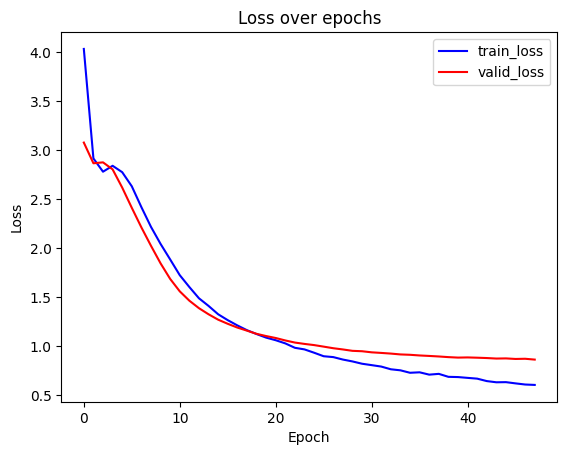

In [230]:
plot_losses(train_losses,valid_losses)

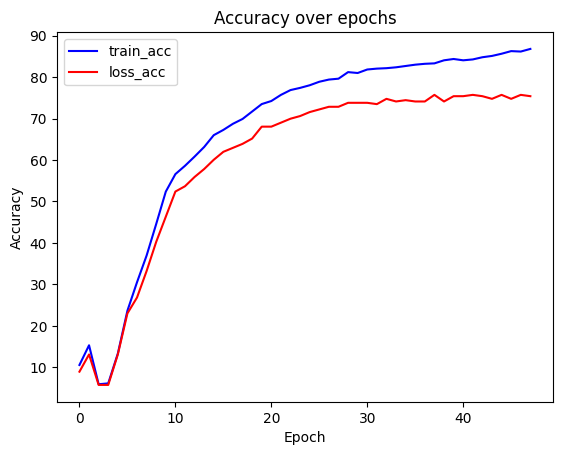

In [231]:
plot_accuracy(train_accuracy,val_accuracy)

In [232]:
get_accuracy(model,valid_loader,device)

75.39936102236422

In [233]:
predicted_labels = []
labels1 = []
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        predicted = torch.argmax(outputs,1)
        predicted_labels.extend(predicted.cpu().numpy())
        labels1.extend(labels.cpu().numpy())

In [234]:
from sklearn.metrics import confusion_matrix
a = confusion_matrix(labels1, predicted_labels)

In [235]:
cnt = 0
total = 0
for i,j in zip(labels1,predicted_labels):
    if i == j:
        cnt +=1
    if i == 25 and i==26:
        total+=1
        
print(cnt*100/total)


ZeroDivisionError: division by zero

In [ ]:
from loader.dataloader import load_data_from_file
classes = load_data_from_file("data/108_data/classes.txt",True)
class_name = []
for key,val in classes.items():
    class_name.append(val)

In [ ]:
import pandas as pd
df_cm = pd.DataFrame(a, index = class_name,
                  columns = class_name)

ValueError: Shape of passed values is (18, 18), indices imply (27, 27)

<Axes: >

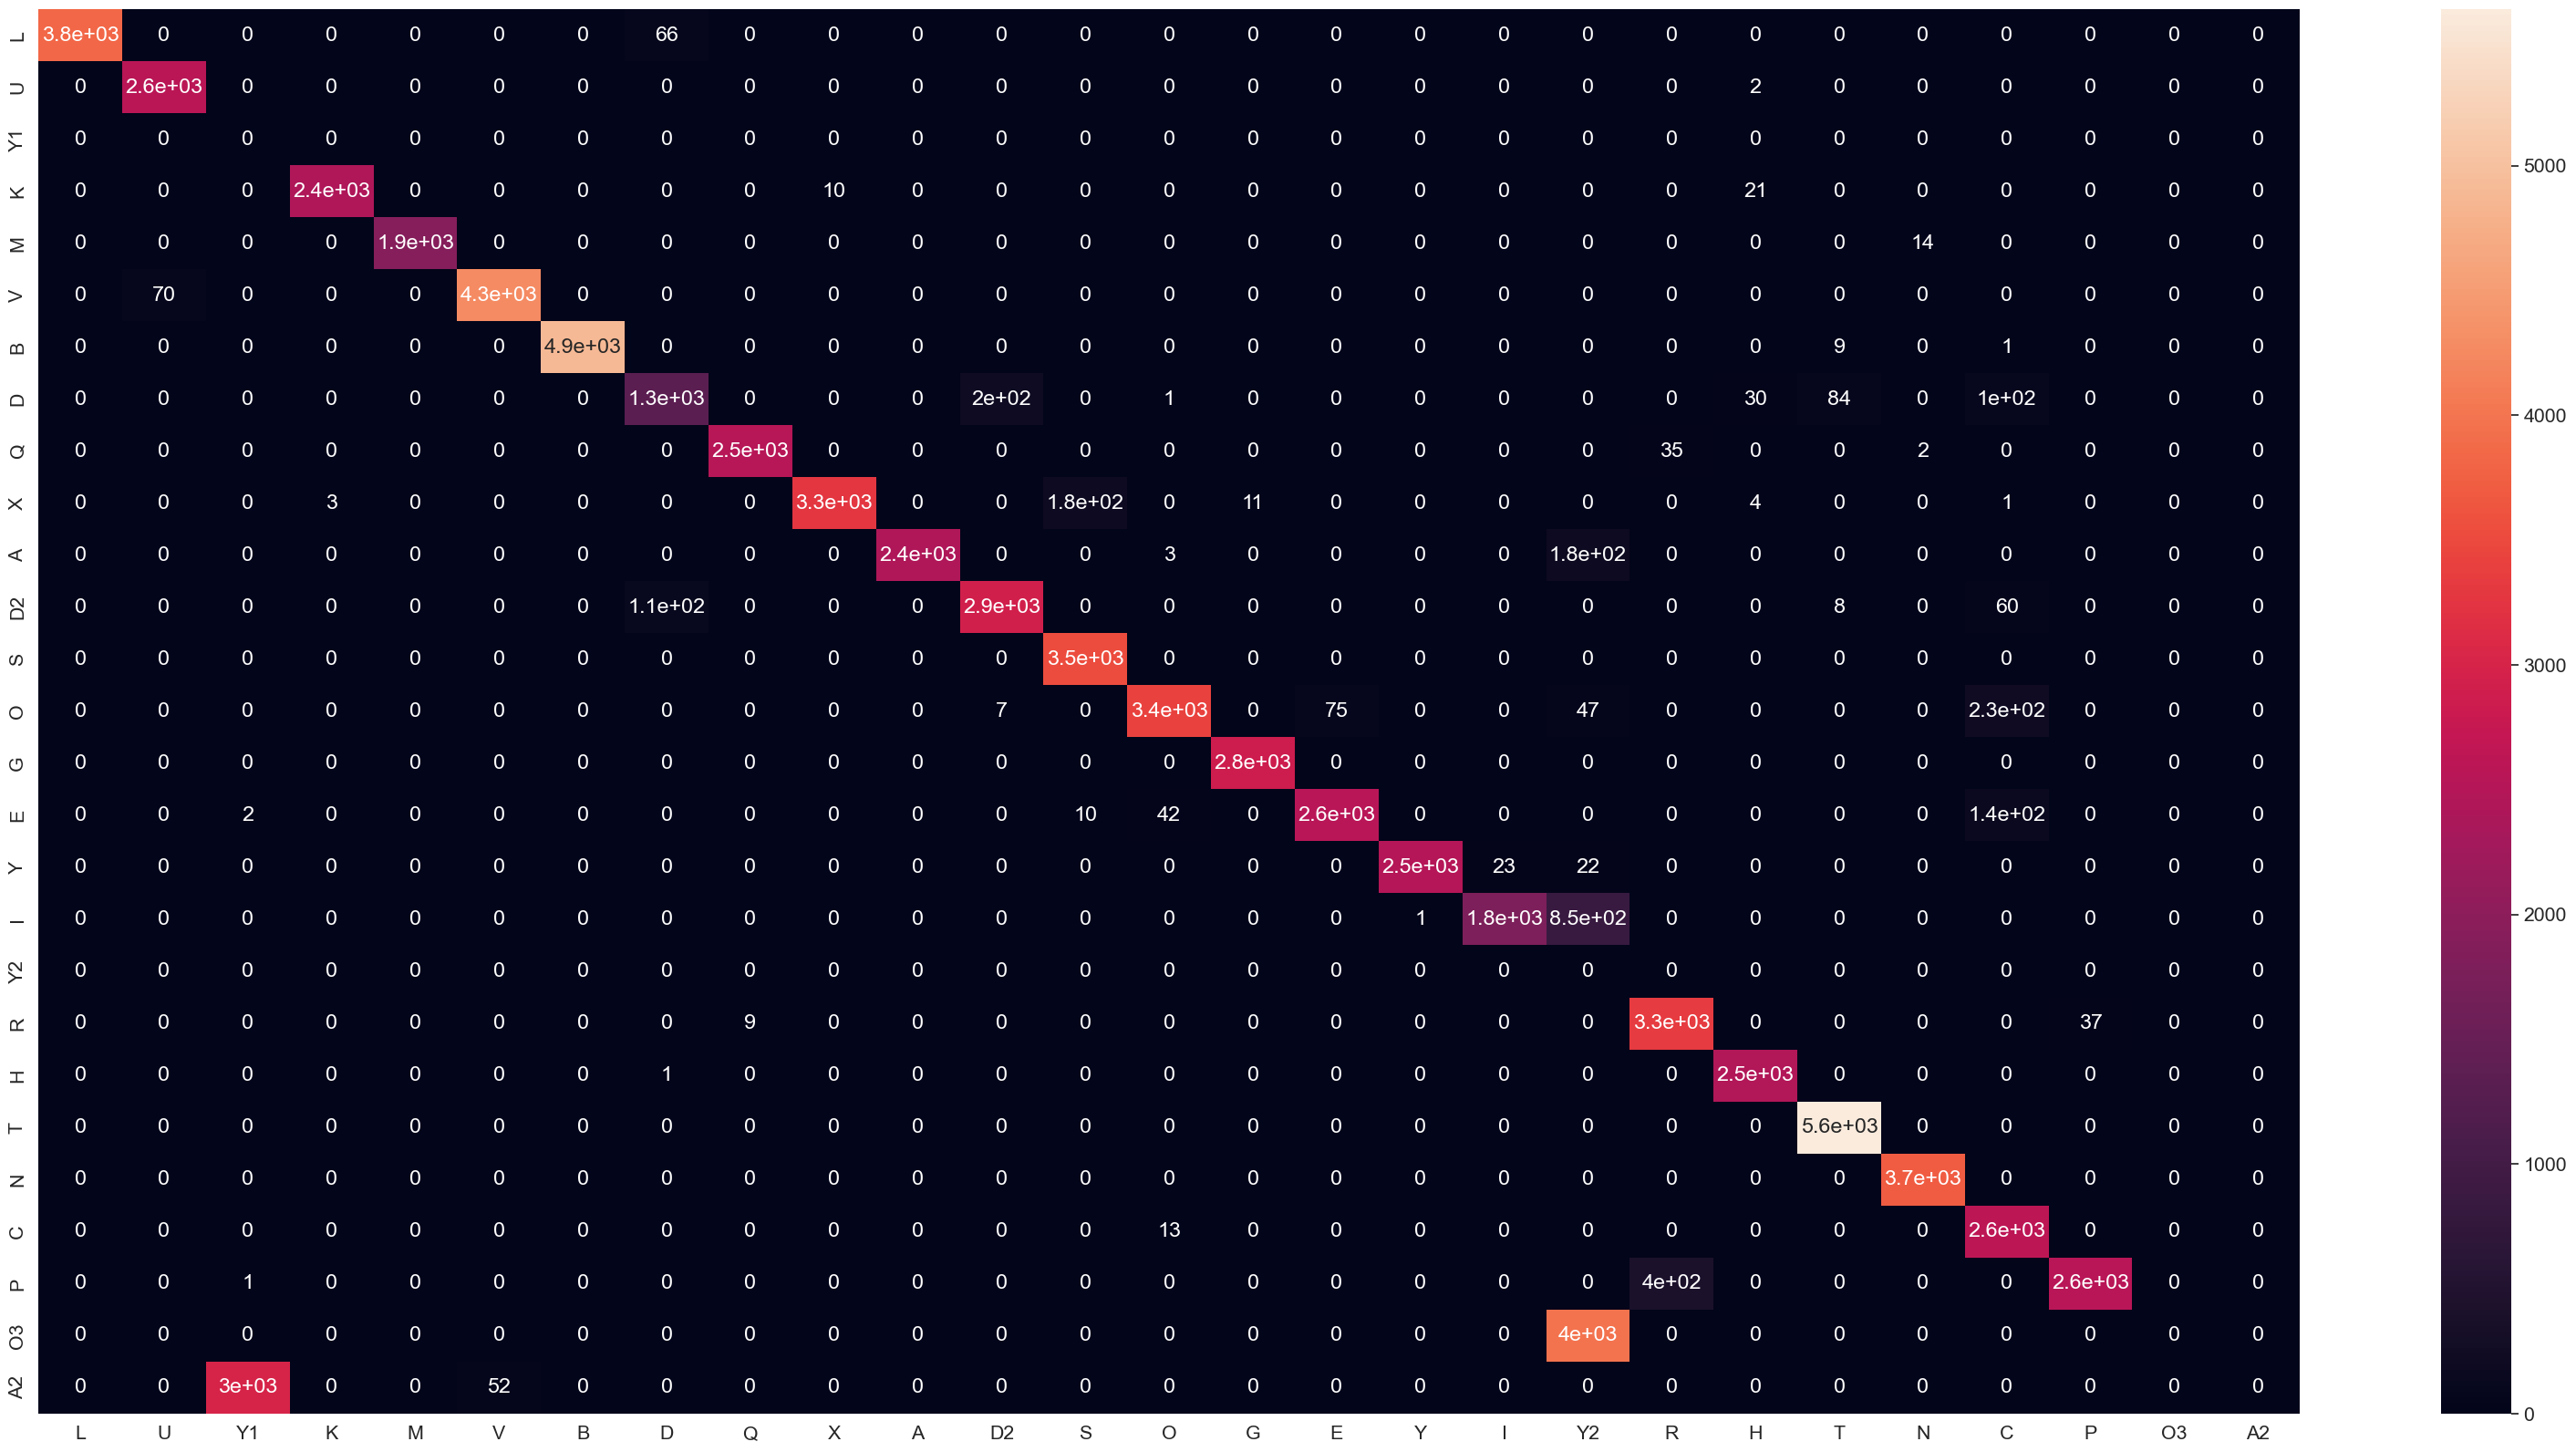

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (40,20))
sn.heatmap(df_cm, annot=True)